## How to use Mathematical Program, and use it to formulate optimizations for robots

One area of tools offered in pydrake is the MathematicalProgram interface.  MathematicalProgram is a class that abstracts many different useful types of optimization solvers.  This makes it so from one interface, you can access many different solvers.  The MathematicalProgram component of Drake is comparable to JuMP, in the Julia ecosystem. To get a concise overview of which solvers are supported for which different types of optimization problems, check out [this chart](http://drake.mit.edu/doxygen_cxx/group__solvers.html).  

As is the case with hot-off-the-presses code, there is not yet a plethora of documentation, but here we're going to try to provide you with enough sample code to help get you started. 

In addition to the code snippets below, these two tips are also very useful:

- Once you construct a MathematicalProgram object, i.e. `mp = MathematicalProgram()`, the tab completion in your jupyter notebook can be very helpful.  

 --> For example, let's say you want to know if a MathematicalProgram can print how many decision variables currently exist.  Tab completing on `mp.` and scrolling through, you'll find `num_vars`.  Indeed `mp.num_vars()` will do the trick.
 
 --> Want to know which solver MP is currently using under the hood for a particular problem instance?
 
```python
mp.Solve() # must first solve the program (which forces a solver to be chosen)
solver = mp.GetSolverId()
solver.name() # name will tab complete after creating a solver object
```
- An additional resource for how to use MathematicalProgram is the tests written for it. There are a significant amount of tests for MathematicalProgram, written in C++.  See [here](https://github.com/RobotLocomotion/drake/blob/master/solvers/test/mathematical_program_test.cc) but also other tests in that folder.  Note however that not all C++ features have pydrake bindings -- for those familiar with pybind, the bindings for MathematicalProgram are generated [here](https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/solvers/mathematicalprogram_py.cc), and are demonstrated in numerous tests [here](https://github.com/RobotLocomotion/drake/tree/master/bindings/pydrake/solvers/test). Obviously though the features  demonstrated below all have pydrake bindings.  There are sufficient features currently in pydrake to satisfiably complete the problem set.

### Okay, but how do I actually do an optimization problem?  

How do we translate something written on the board as a linear program, and write it down in code?

Here is a very simple example of an LP:

\begin{align*}
        \min_{x} \ \ \ x \\
        s.t. \ \ \  & x >= 1 \\
\end{align*}

And the corresponding Mathematical Program code is below.

In [1]:
from pydrake.all import MathematicalProgram
import numpy as np
import math

In [4]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(1, "x")
mp.AddLinearCost(x[0]*1.0)
mp.AddLinearConstraint(x[0] >= 1)
print mp.Solve()
print mp.GetSolution(x)

SolutionResult.kSolutionFound
[1.]


Note that written down slightly incorrectly, you will not get the answer you were looking for.  What is wrong about the two examples below?

In [5]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(1, "x")
mp.AddLinearCost(x[0]*1.0)
print mp.Solve()
print mp.GetSolution(x)

SolutionResult.kUnbounded
[nan]


In [6]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(1, "x")
mp.AddLinearCost(x[0]*1.0)
mp.AddLinearConstraint(x[0] <= 1)
mp.Solve()
print mp.Solve()
print mp.GetSolution(x)

SolutionResult.kIterationLimit
[-3000.0001411]


Here's a slightly more complicated example, this one solves a problem that may look familiar to you.

This is just one example of how, even though Linear Programs can only handle linear objectives and constraints, you can use them to sample over arbitrarily complex functions, and the samples of those functions can still be just linear constraints / objectives.

In [ ]:
mp = MathematicalProgram()
alpha = mp.NewContinuousVariables(1, "alpha")
mp.AddLinearCost(alpha[0]*1.0)
for xi in np.arange(-5*np.pi, 5*np.pi+np.pi/8, np.pi/8):
    mp.AddLinearConstraint(alpha[0] - math.cos(xi)**2 + math.sin(xi) >= 0)
    
mp.Solve()
print mp.GetSolution(alpha)

Note the MathematicalProgram is formulated in terms of "costs", and will minimize the objective function's costs when calling `Solve()`.  How can we maximize functions? Just add a negative sign:

In [ ]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(1, "x")
mp.AddLinearCost(-x[0]*1.0)
mp.AddLinearConstraint(x[0] <= 4)
mp.Solve()
print mp.GetSolution(x)

Now how about if we want to go outside the realm of Linear Programs?  What if we want to do a Quadratic Program?  Recall that the only difference between a quadratic program and a Linear Program is that QPs now allow a quadratic cost, but still only linear objectives.

In [7]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(1, "x")
mp.AddQuadraticCost((x[0]-3)**2)
mp.Solve()
print mp.GetSolution(x)

[3.]


Note that as above, a QP can be well formulated even without any constraints.  (LPs will have unbounded objectives without constraints.)

Note that there is no `QuadraticConstraint` in MathematicalProgram.  Why not?  (What class of problem is a QuadraticConstraint?)

But actually although there is no specific function call for it, MathematicalProgram can generally handle a quadratic constraint, and many other different types of constraints, through `AddConstraint`, where inside the argument to the function is a symbolic formula of type `==`, `>=`, or `<=`.  This opens up MathematicalProgram to solve general nonlinear optimization problems.

In [8]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(2, "x")
mp.AddConstraint((x**2).sum() == 1.)
mp.AddLinearCost(x.sum())
mp.Solve()
print mp.GetSolution(x)

[-0.70710678 -0.70710678]


Alternatively you can even use many numpy operations, including `dot`:

In [9]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(2, "x")
mp.AddConstraint(x.dot(x) == 1.)
mp.AddLinearCost(x.sum())
mp.Solve()
print mp.GetSolution(x)

[-0.70710678 -0.70710678]


The above type of constraint will be very useful for our trajectory optimizations, which are in general nonlinear for sufficiently complex problems.

Note below that for the Mixed-Integer class of problems, the two solvers supported by Drake (as you can see from the chart linked above) are both proprietary solvers and not shipped with the docker image.  You may want to delve into this class of problems for final projects, however, and we can help you get access to these solvers if needed.  Gurobi is very powerful and availble for free for academic use, although will not work easily in a docker image and so we'd suggest a native Drake installation.

In [ ]:
# This needs a commercial solver to work...
# mp = MathematicalProgram()
# x = mp.NewContinuousVariables(1, "x")
# b = mp.NewBinaryVariables(1, "b")
# mp.AddLinearConstraint(x[0] <= 1)
# mp.Solve()
# print mp.GetSolution(x)

Note that you can print out useful prints at many steps of interacting with Mathematical Program, for example:

In [10]:
mp = MathematicalProgram()
x = mp.NewContinuousVariables(2, "x")
print type(x)
print x

<type 'numpy.ndarray'>
[Variable('x(0)') Variable('x(1)')]


In [11]:
y = x**2
print y

[<Expression "pow(x(0), 2)"> <Expression "pow(x(1), 2)">]


# The simplest use of MathematicalProgram we could think of for a useful "robot" optimization  

Let's imagine we have a ball that we want to shoot ballistically out of a cannon to a certain point in space.

Our cannon is very sophisticated and let's us choose precisely the intial velocity of the ball, but once the ball has left the cannon, it's out of our control.

We can set up a very simple sim below to simulate this ball.

(1000, 4)


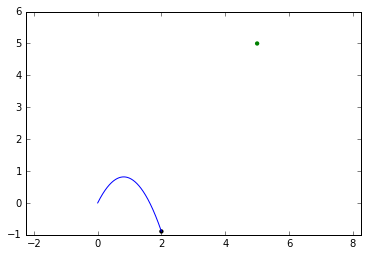

In [14]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
from matplotlib.patches import Circle
%matplotlib inline

G = 9.8  # gravity, in m/s^2

def dynamics(state, t):
    ball_position = state[0:2]
    derivs = np.zeros_like(state)
    derivs[0:2] = state[2:4]
    derivs[2]  = 0
    derivs[3]  = -G
    
    return derivs

dt = 0.001
time_array = np.arange(0.0, 1, dt)

state_initial = np.asarray([0, 0, 2, 4])

# integrate using scipy integrate which will do runge-kutta integration probably
state_over_time = integrate.odeint(dynamics, state_initial, time_array)

print state_over_time.shape

ball_position_x = state_over_time[:,0]
ball_position_y = state_over_time[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(ball_position_x, ball_position_y)
circ = Circle((ball_position_x[-1],ball_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

If our goal is to choose the initial velocity so that we make it to the green dot at the top right, then this is a problem we can solve.

This is actually a problem that can be pretty easily solved in closed form, but it's also pretty easy to throw the optimization hammer at the problem.

In [15]:
from pydrake.all import MathematicalProgram
mp = MathematicalProgram()

velocity_initial = mp.NewContinuousVariables(2, "velocity_initial")
state_initial = np.asarray([0, 0, velocity_initial[0], velocity_initial[1]])

num_time_steps = len(time_array)
states_over_time = np.asarray([state_initial])

for i in range(num_time_steps):
    # Here this just uses euler integration
    state_next = states_over_time[-1,:] + dt*dynamics(states_over_time[-1,:],0)
    states_over_time = np.vstack((states_over_time, state_next))

# Calculate final position error
position_goal = np.asarray([5,5])
final_position_error = position_goal - states_over_time[-1,0:2]

mp.AddQuadraticCost((final_position_error).dot(final_position_error))
mp.Solve()
print mp.GetSolution(velocity_initial)
optimal_initial_veloctiy = mp.GetSolution(velocity_initial)

[5.     9.8951]


[0.     0.     5.     9.8951]
(1000, 4)


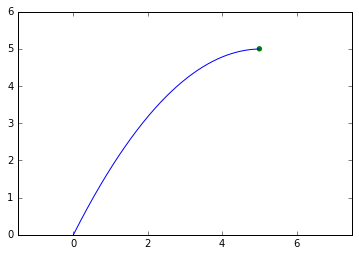

In [16]:
# Simulate given the initial velocity
state = np.asarray([0, 0, optimal_initial_veloctiy[0], optimal_initial_veloctiy[1]])
print state

# We can check our euler integration back against the scipy integration
state_over_time = integrate.odeint(dynamics, state, time_array)
print state_over_time.shape

ball_position_x = state_over_time[:,0]
ball_position_y = state_over_time[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(ball_position_x, ball_position_y)
circ = Circle((ball_position_x[-1],ball_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

In the first example optimization above, we used a quadratic cost on final position error.

What if we just constrain the problem to exactly reach the position?  We can also, for example, add a quadratic cost on the total initial speed of the ball.

In [17]:
from pydrake.all import MathematicalProgram
mp = MathematicalProgram()

velocity_initial = mp.NewContinuousVariables(2, "velocity_initial")
state_initial = np.asarray([0, 0, velocity_initial[0], velocity_initial[1]])

num_time_steps = len(time_array)
states_over_time = np.asarray([state_initial])

for i in range(num_time_steps):
    state_next = states_over_time[-1,:] + dt*dynamics(states_over_time[-1,:],0)
    states_over_time = np.vstack((states_over_time, state_next))

# Calculate final position error
position_goal = np.asarray([5,5])
final_position_error = position_goal - states_over_time[-1,0:2]

mp.AddQuadraticCost(1 * velocity_initial.dot(velocity_initial))
print position_goal
mp.AddLinearConstraint(states_over_time[-1,0] >= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,0] <= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,1] >= position_goal[1])
mp.AddLinearConstraint(states_over_time[-1,1] <= position_goal[1])
mp.Solve()
print mp.GetSolution(velocity_initial)

[5 5]
[5.     9.8951]


[0.     0.     5.     9.8951]
(1000, 4)


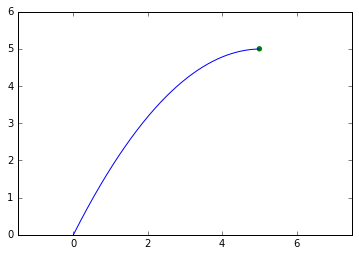

In [18]:
# Simulate given the initial velocity
state = np.asarray([0, 0, optimal_initial_veloctiy[0], optimal_initial_veloctiy[1]])
print state

# We can check our euler integration back against the scipy integration
state_over_time = integrate.odeint(dynamics, state, time_array)
print state_over_time.shape

ball_position_x = state_over_time[:,0]
ball_position_y = state_over_time[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(ball_position_x, ball_position_y)
circ = Circle((ball_position_x[-1],ball_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

## Now what if we have a couple rocket boosters attached?

The problem gets a little bit more interesting if we have a couple of rocket boosters attached to our ball.

We can now ask this problem:

  --> If for the first 100 time steps, we can use the rocket boosters on the ball to adjust its trajectory, then what can we do?

In [19]:
mp = MathematicalProgram()

velocity_initial = mp.NewContinuousVariables(2, "velocity_initial")
state_initial = np.asarray([0, 0, velocity_initial[0], velocity_initial[1]])

num_time_steps = 1000
states_over_time = np.asarray([state_initial])

num_steps_with_boosters = 100

k = 0
u = mp.NewContinuousVariables(2, "u_%d" % k)
u_over_time = u

for k in range(1,num_steps_with_boosters):
    u = mp.NewContinuousVariables(2, "u_%d" % k)
    u_over_time = np.vstack((u_over_time, u))

total_u = np.vstack((u_over_time,np.zeros((900,2))))
    
print "Number of decision vars", mp.num_vars()

states_over_time = np.asarray([state_initial])
def derivs_with_boosters(state, t):
    index = int(t*num_time_steps)
    u = total_u[index]
    rocket_position = state[0:2]
    derivs = np.zeros_like(state)
    derivs[0:2] = state[2:4]
    derivs[2]  = 0 + u[0]
    derivs[3]  = -G + u[1]
    
    return derivs

for i in range(num_time_steps):
    state_next = states_over_time[-1,:] + .001*derivs_with_boosters(states_over_time[-1,:],time_array[i])
    states_over_time = np.vstack((states_over_time, state_next))


# Calculate final position error
position_goal = np.asarray([5,5])
final_position_error = position_goal - states_over_time[-1,0:2]

mp.AddLinearConstraint(velocity_initial[0] <= 20)
mp.AddLinearConstraint(velocity_initial[1] <= 2)

mp.AddQuadraticCost(1 * velocity_initial.dot(velocity_initial))
mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))
mp.AddQuadraticCost(1 * u_over_time[:,1].dot(u_over_time[:,1]))

mp.AddLinearConstraint(states_over_time[-1,0] >= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,0] <= position_goal[0])
mp.AddLinearConstraint(states_over_time[-1,1] >= position_goal[1])
mp.AddLinearConstraint(states_over_time[-1,1] <= position_goal[1])
mp.Solve()

print "velocity_initial computed", mp.GetSolution(velocity_initial)

optimal_initial_veloctiy = mp.GetSolution(velocity_initial)
u_over_time = mp.GetSolution(u_over_time)
total_u = np.vstack((u_over_time,np.zeros((900,2))))

Number of decision vars 202
velocity_initial computed [4.99954885 2.00950369]


(1001, 4)


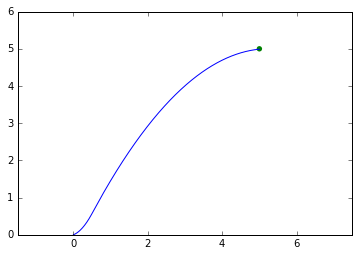

In [20]:
state_initial = np.asarray([0, 0, optimal_initial_veloctiy[0], optimal_initial_veloctiy[1]])

states_over_time = np.asarray([state_initial])
for i in range(num_time_steps):
    state_next = states_over_time[-1,:] + .001*derivs_with_boosters(states_over_time[-1,:],time_array[i])
    states_over_time = np.vstack((states_over_time, state_next))

print states_over_time.shape
    
y = states_over_time

rocket_position_x = y[:,0]
rocket_position_y = y[:,1]

fig, axes = plt.subplots(nrows=1,ncols=1)
axes.plot(rocket_position_x, rocket_position_y)
circ = Circle((rocket_position_x[-1],rocket_position_y[-1]), radius=0.1, facecolor='k', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
circ = Circle((5,5), radius=0.1, facecolor='green', edgecolor='white', fill=True ,linewidth = 2.0, linestyle='solid')
axes.add_patch(circ)
axes.axis('equal')
plt.show()

# Good luck!

Hopefully that was enough of an initial introduction to help get you started on the orbit transfer problem.

Please ask questions on Piazza and/or come to office hours if you have any more questions.